# Project 1 - AR Tag Detection

### Imports

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, ifft
import math
import moviepy.editor as mpy
from helper_functions import *
%config Completer.use_jedi = False

### Functions

In [3]:
path_mT = '../Data/multipleTags.mp4' # 1012 frames
path_0 = '../Data/Tag0.mp4' # 554
path_1 = '../Data/Tag1.mp4' # 660
path_2 = '../Data/Tag2.mp4' # 667

# Problem 1a

### Code: 

In [5]:
def imRead(path = './Data/Tag1.mp4'):
    startFlag = True
    counter = 1
    cap = cv2.VideoCapture(path)    
    while(True):
        if startFlag==True:
            ret, frame = cap.read()
            if ret:
                frame  = cv2.resize(frame, (512,512))
                startFlag = False
                break
        else:
            counter+=1
            if counter ==10:
                break
    cap.release()
    
    return frame

def Tag_using_FFT(im_org):
    
    im = cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY)
    im = cv2.GaussianBlur(im,(3,3),0.2)
    dft = cv2.dft(np.float32(im),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    mask = getCircularMask(dft_shift.shape, radius=30)
#     mask+=1
#     mask[mask==2] = 0
    
    fshift = dft_shift*mask
    magnitude_spectrum_lp = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
    f_ishift = np.fft.ifftshift(fshift)
    im_ = cv2.idft(f_ishift)
    im_ = cv2.magnitude(im_[:,:,0],im_[:,:,1])
    im_ = cv2.normalize(im_, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    _, binary = cv2.threshold(im_, 20, 255, cv2.THRESH_BINARY) 
    kernel = np.ones((3,3),np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    Area_List = []
    for c in contours:
        Area_List.append(cv2.contourArea(c))
    i = np.argmax(np.array(Area_List))
    rect = cv2.boundingRect(contours[i])
    x,y,w,h = rect
    margin = 10
    AR_tag = im_org[y-margin:y+h+margin,x-margin:x+w+margin] # with 10pixel pad margin

    _, binary = cv2.threshold(cv2.cvtColor(AR_tag, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # find the contours of white space since directly finding AR contours is erroneous
    AR_contour = contours[1]                          # should find all parents with heirarchy
    AR_corners = cv2.approxPolyDP(AR_contour,0.13*cv2.arcLength(AR_contour,True),True) 

    size = 20
    reference_corners = np.array([[0,0],[size,0],[size,size],[0,size]]).reshape(-1,1,2)
    H = Homography(np.float32(AR_corners), np.float32(reference_corners))

    imOut = np.zeros((size,size,3),dtype = np.uint8)
    warped_AR_tag = Warp_(AR_tag, H, imOut)
    warped_AR_tag  = cv2.resize(warped_AR_tag, (128,128)) # linear interpolation 

    return magnitude_spectrum, magnitude_spectrum_lp, im_, AR_tag, warped_AR_tag

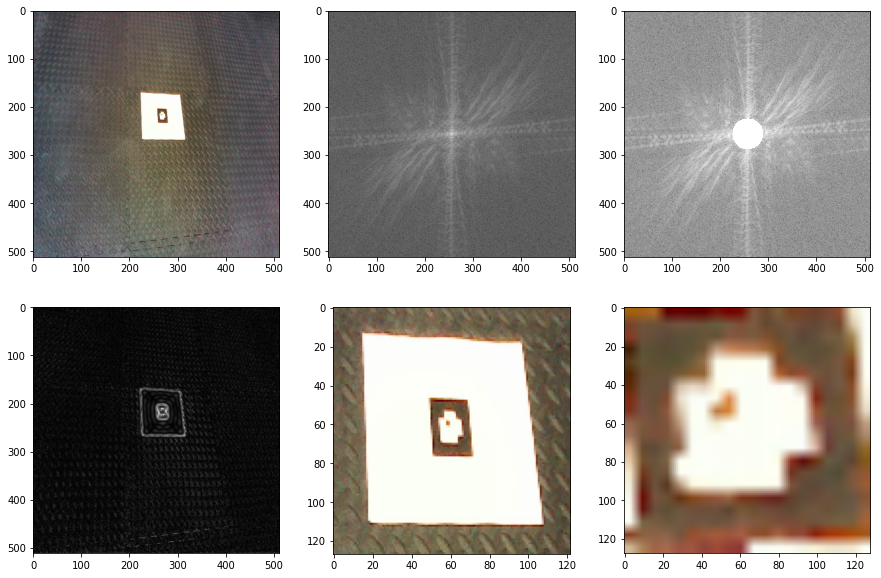

In [6]:


im_org = imRead(path_1)
magnitude_spectrum, magnitude_spectrum_lp, im_, AR_tag, AR_block = Tag_using_FFT(im_org)

fig,plts = plt.subplots(2,3,figsize = (15,10))
plts[0][0].imshow(im_org,'gray')
plts[0][1].imshow(magnitude_spectrum,'gray')
plts[0][2].imshow(magnitude_spectrum_lp,'gray')
plts[1][0].imshow(im_,'gray')
plts[1][1].imshow(AR_tag,'gray')
plts[1][2].imshow(AR_block)    

# Problem 1b

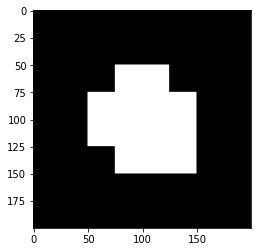

In [7]:
# im_org = imRead(path_0)
AR_block = cv2.imread('../Data/ref_marker.png')
plt.imshow(AR_block)
orientation,decodedValue,rotated_AR_block = getOrientation_2(AR_block,decode=True)

Bit Value:  1.0 1.0 1.0 1.0
Decoded Result : 15.0
0


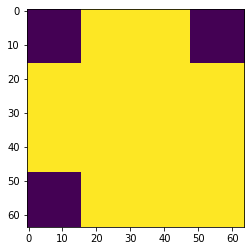

In [43]:
# _, AR_block = cv2.threshold(cv2.cvtColor(AR_block, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY)
# _, _, _,_, AR_block = Tag_using_FFT(im_org)
orientation,decodedValue,rotated_AR_block = getOrientation_2(AR_block,decode=True)

print(orientation)
plt.imshow(rotated_AR_block)

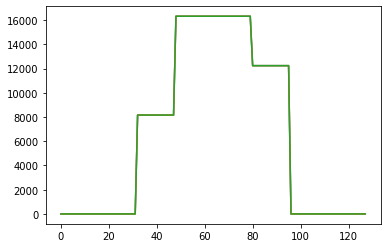

In [42]:
"""
For a given AR tag, crop the black region

"""
AR_block  = cv2.resize(AR_block, (128,128)) # linear interpolation

Xdistribution = np.sum(AR_block,axis=0)
Ydistribution = np.sum(AR_block,axis=1)
plt.plot(Xdistribution)

# Problem 2

### Load template

In [2]:
testudoPath = "../Data/testudo.png" 
testudoBlock = cv2.imread(testudoPath)
testudoBlock  = cv2.resize(testudoBlock, (64,64))
testudoBlock = cv2.cvtColor(testudoBlock, cv2.COLOR_RGB2BGR)
# flip the template here since orientation function for AR is returns in opposite direction
testudoBlock= cv2.flip(testudoBlock, 0)  

1012


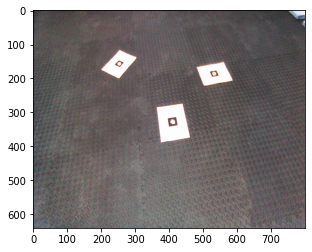

In [8]:
imgs = videoRead(path_mT)
print(len(imgs))
plt.imshow(imgs[0])

### Functions

In [38]:
def Warp_(src, H , dst):
    """ To perform warping,
    Apply H on every pixel location from src (a,b ,c=1) to find destination location x,y,z
    since z doesnt exist, do x = x/z, y = y/z , so z = 1
    
    if x and y locations are within the boundaries of dst image shape,
    paste the value from src [a,b] at dst [x,y]
    """
    im = cv2.transpose(src)
    height,width = im.shape[:2]
    h_limit, w_limit = dst.shape[:2]
    for a in range(width):
        for b in range(height):
            ab1 = np.array([a ,b, 1])
            x,y,z = H.dot(ab1)
            x,y = int(x/z), int(y/z)
            if (x >= 0 and x < w_limit) and (y >= 0 and y < h_limit) :
                    dst[int(y),int(x)] = im[a ,b]
    
    return dst

def TagRotateDecode_(im_org,AR_corners,testudoBlock,size = 22,out_size = 128 ):

    reference_corners = np.array([[0,0],[0,size],[size,size],[size,0]]).reshape(-1,1,2)
    H = Homography(np.float32(AR_corners), np.float32(reference_corners))
    ### decode the AR and find the orientation to flip testudo
#     imOut_AR = np.zeros((size,size,3),dtype = np.uint8)
#     warped_AR_tag = Warp(im_org, H, imOut_AR)
    
    warped_AR_tag = cv2.warpPerspective(im_org, H, dsize =(size,size)) # cv2 warp
    warped_AR_tag  = cv2.resize(warped_AR_tag, (128,128)) # linear interpolation
    
        
    
    orientation, decodedValue,_ = getOrientation_2(warped_AR_tag,margin=10, decode = True)
    testudoBlock = RotatebyOrientation(testudoBlock, orientation)

    return testudoBlock, decodedValue,warped_AR_tag

def RunoneFrame(im_org, testudoBlock):
    """
    run the first frame to, find the orientation of the AR, align the testudo in the correct orientation.
    decode the AR and return the decodedvalue
    """

    _, binary = cv2.threshold(cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY) 
    kernel = np.ones((3,3),np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    AR_contours = []
    parentFlag = -1
    childFlag = 0
    hierarchy = hierarchy[0]

    ## Find the AR contours
    for i,h in enumerate(hierarchy):
        nxt,prev,child, parent =  h    

        if (parent == -1) and (child > -1) :  # find a parent
            parentFlag = 1
            continue

        if (parent > -1) and (child > -1) and (parentFlag == 1) : # find the first child - has a parent(whiteRegion) ,a child(inner artifacts) 
            parentFlag = 0 # after finding the first child, we set this to ignore the inner children
            AR_contours.append(contours[i])


    testudoBlocks,decodedValues,rotated_AR_blocks,warpedTags = [],[],[],[]
    
    multiTagFlag = False
    if (len(AR_contours)>0) and (len(AR_contours)<4) :
        
        if len(AR_contours) == 3:
            multiTagFlag = True
            print("---------------------------------------------------------------------")
            print("Multiple Tags found: even cv2.warpPerspective function cannot decode all tags accurately")            
            print("Wrong decoding will be resulted in first frame, Decoding AR correctly in Last Frame....")
            print("Orientation of the Testudo Template might not be accurate.....")
            print("---------------------------------------------------------------------")
            
        for contour in AR_contours: # get corners for every contour
            AR_corners = cv2.approxPolyDP(contour,0.11*cv2.arcLength(contour,True),True) 
            if (len(AR_corners) == 4) :                
                      ### predefined functions
#                     reference_corners = np.array([[0,0],[0,64],[64,64],[64,0]]).reshape(-1,1,2)
#                     H = cv2.getPerspectiveTransform(np.float32(AR_corners), np.float32(reference_corners))
#                     warped_AR_tag = cv2.warpPerspective(im_org, H, dsize =(64,64))

                ### custom functions:
                size = 22            
                reference_corners = np.array([[0,0],[0,size],[size,size],[size,0]]).reshape(-1,1,2)
                H = Homography(np.float32(AR_corners), np.float32(reference_corners))
                imOut = np.zeros((size,size,3),dtype = np.uint8)
                warped_AR_tag = Warp(im_org, H, imOut)
                warped_AR_tag  = cv2.resize(warped_AR_tag, (64,64)) # linear interpolation                     
                
                orientation, decodedValue,_ = getOrientation_2(warped_AR_tag,margin=10, decode = True)
                testudoBlock = RotatebyOrientation(testudoBlock, orientation)
                                
    return multiTagFlag, testudoBlock, decodedValue



### Do for one Image

---------------------------------------------------------------------
Multiple Tags found: even cv2.warpPerspective function cannot decode all tags accurately
Wrong decoding will be resulted in first frame, Decoding AR correctly in Last Frame....
Orientation of the Testudo Template might not be accurate.....
---------------------------------------------------------------------
Decoded Value:  13.0
Decoded Value:  9.0
Decoded Value:  15.0


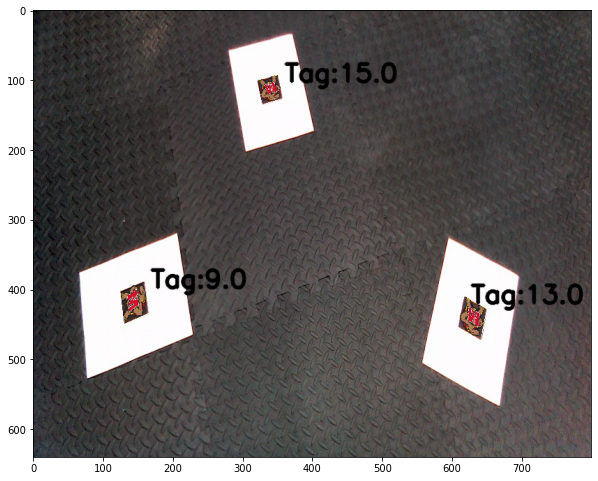

In [54]:
size = 128

testudoPath = "../Data/testudo.png" 

testudoBlock = cv2.imread(testudoPath)
testudoBlock  = cv2.resize(testudoBlock, (size,size))
testudoBlock = cv2.cvtColor(testudoBlock, cv2.COLOR_RGB2BGR)

im_org = imgs[1011]

_,testudoBlock, decodedValue = RunoneFrame(im_org, testudoBlock)

imOut = im_org.copy()
_, binary = cv2.threshold(cv2.cvtColor(im_org, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY) 
kernel = np.ones((3,3),np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

AR_contours = []
parentFlag = -1
childFlag = 0
hierarchy = hierarchy[0]

## Find the AR contours
for i,h in enumerate(hierarchy):
    nxt,prev,child, parent =  h    
    
    if (parent == -1) and (child > -1) :  # find a parent
        parentFlag = 1
        continue
        
    if (parent > -1) and (child > -1) and (parentFlag == 1) : # find the first child - has a parent(whiteRegion) ,a child(inner artifacts) 
        parentFlag = 0 # after finding the first child, we set this to ignore the inner children
        AR_contours.append(contours[i])

## to print the contours
im_contours = im_org.copy()
im_contours = cv2.drawContours(im_contours, AR_contours, -1, (205, 0, 250), 4)

firstime = 0
if (len(AR_contours)>0) and (len(AR_contours)<4) :
    # get corners for every contour
    for contour in AR_contours:
        
        AR_corners = cv2.approxPolyDP(contour,0.11*cv2.arcLength(contour,True),True) 
        if (len(AR_corners) == 4) :
            
            testudoBlock,decodedValue = TagRotateDecode(im_org,AR_corners,testudoBlock,size = 22,out_size = size)
            print("Decoded Value: ", decodedValue)
            Tags.append(Tag)
            ## warp testudo to the AR location in video
            reference_corners = np.array([[0,0],[0,size],[size,size],[size,0]]).reshape(-1,1,2)
#             H = cv2.getPerspectiveTransform(np.float32(AR_corners), np.float32(reference_corners)) # cv2 Homography
            H = Homography(np.float32(AR_corners), np.float32(reference_corners))   # custom HomoGraphy
#             warpedTestudo = cv2.warpPerspective(testudoBlock, np.linalg.inv(H), dsize =(im_org.shape[1],im_org.shape[0])) # cv2 warp
            warpedTestudo = Warp(testudoBlock,np.linalg.inv(H), np.zeros_like(im_org))      # custom Warp
            _, warpedTestudo_mask = cv2.threshold(cv2.cvtColor(warpedTestudo, cv2.COLOR_BGR2GRAY), 20, 255, cv2.THRESH_BINARY_INV)
            
            warpedTestudo_mask = np.dstack((warpedTestudo_mask,warpedTestudo_mask,warpedTestudo_mask))
            imOut = cv2.bitwise_and(imOut, warpedTestudo_mask)
            imOut = cv2.addWeighted(imOut, 1.0, warpedTestudo, 1.0, 0)
            text_location = tuple(AR_corners.squeeze()[0] + 10)
            text = "Tag:"+str(decodedValue)
            imOut = cv2.putText(imOut, text, text_location, cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0) ,3, cv2.LINE_AA, False) 

            
fig = plt.figure(figsize = (10,10))
plt.imshow(imOut)            


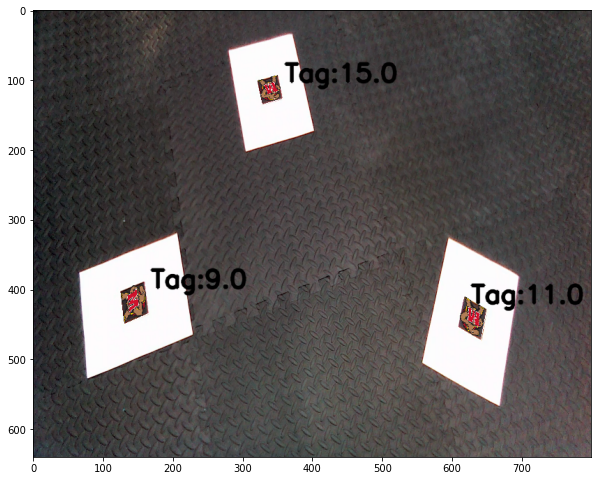

In [80]:
fig = plt.figure(figsize = (10,10))
plt.imshow(imOut)
fig.savefig('multiTags.png')

### Do for the entire video

### Writing WarpPerspective from scratch
- function exported

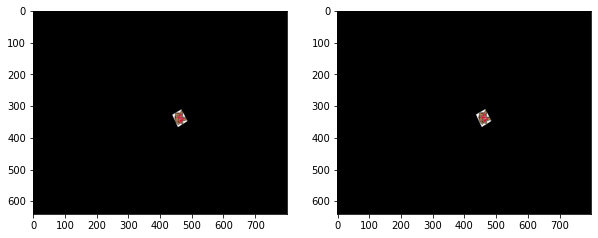

In [387]:


customwarpedTestudo = customWarp(testudoBlock,np.linalg.inv(H), im_out)
warpedTestudo = cv2.warpPerspective(testudoBlock, np.linalg.inv(H), dsize =(im_org.shape[1],im_org.shape[0]))

H_inv = np.linalg.inv(H)
im_out=np.zeros_like(im_org)

_,plts = plt.subplots(1,2,figsize = (10,5))
plts[0].imshow(warpedTestudo)
plts[1].imshow(customwarpedTestudo)

# Projection cube

In [249]:
K = np.array([[1406.08415449821,2.20679787308599,1014.13643417416],
            [0.0000000000, 1417.99930662800,566.347754321696],
            [0.0000000000, 0.0000000000,1.0000000000]])

def getCorners(c):
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    return np.array([[np.array(extLeft), np.array(extRight) , np.array(extTop) , np.array(extBot)]]).reshape(-1,1,2)


def ProjectionMatrix(H):
    global K
    h1, h2, h3 = H[:,0], H[:,1], H[:,2]
    K_inv = np.linalg.inv(K) 
    lamda = ((np.linalg.norm(K_inv.dot(h1)) + np.linalg.norm(K_inv.dot(h2)) )/2)**(-1)
    B_ = lamda*K_inv.dot(H)

    if np.linalg.det(B_) > 0 :
        B = B_
    else:
        B = - B_

    r1, r2, r3 = B[:,0], B[:,1], np.cross(B[:,0], B[:,1])
    t = B[:,2]

    RTmatrix = np.dstack((r1,r2,r3,t)).squeeze()
    P = K.dot(RTmatrix)
    return P


def getCubeCoordinates(P,cube_size = 128):

    x1,y1,z1 = P.dot([0,0,0,1])
    x2,y2,z2 = P.dot([0,cube_size,0,1])
    x3,y3,z3 = P.dot([cube_size,0,0,1])
    x4,y4,z4 = P.dot([cube_size,cube_size,0,1])

    x5,y5,z5 = P.dot([0,0,-cube_size,1])
    x6,y6,z6 = P.dot([0,cube_size,-cube_size,1])
    x7,y7,z7 = P.dot([cube_size,0,-cube_size,1])
    x8,y8,z8 = P.dot([cube_size,cube_size,-cube_size,1])

    X = [x1/z1 ,x2/z2 ,x3/z3 ,x4/z4 ,x5/z5 ,x6/z6 ,x7/z7 ,x8/z8] 
    Y = [y1/z1 ,y2/z2 ,y3/z3 ,y4/z4 ,y5/z5 ,y6/z6 ,y7/z7 ,y8/z8] 
    XY = np.dstack((X,Y)).squeeze().astype(np.int32)
    
    return XY

def drawCube(im_org, XY):
    im_print = im_org.copy()
    for xy_pts in XY:
        x,y = xy_pts
        cv2.circle(im_print,(x,y), 5, (0,0,255), -1)

    im_print = cv2.line(im_print,tuple(XY[0]),tuple(XY[1]), (0,255,255), 5)
    im_print = cv2.line(im_print,tuple(XY[0]),tuple(XY[2]), (0,255,255), 5)
    im_print = cv2.line(im_print,tuple(XY[0]),tuple(XY[4]), (0,255,255), 5)
    im_print = cv2.line(im_print,tuple(XY[1]),tuple(XY[3]), (0,225,255), 5)
    im_print = cv2.line(im_print,tuple(XY[1]),tuple(XY[5]), (0,225,255), 5)
    im_print = cv2.line(im_print,tuple(XY[2]),tuple(XY[6]), (0,200,255), 5)
    im_print = cv2.line(im_print,tuple(XY[2]),tuple(XY[3]), (0,200,255), 5)
    im_print = cv2.line(im_print,tuple(XY[3]),tuple(XY[7]), (0,175,255), 5)
    im_print = cv2.line(im_print,tuple(XY[4]),tuple(XY[5]), (0,150,255), 5)
    im_print = cv2.line(im_print,tuple(XY[4]),tuple(XY[6]), (0,150,255), 5)
    im_print = cv2.line(im_print,tuple(XY[5]),tuple(XY[7]), (0,125,255), 5)
    im_print = cv2.line(im_print,tuple(XY[6]),tuple(XY[7]), (0,100,255), 5)

    return im_print


In [250]:




P = ProjectionMatrix(np.linalg.inv(H))
XY = getCubeCoordinates(P,cube_size = 128)
imOut = drawCube(im_org, XY)
AR_corners = getCorners(c)

# Just for References: 

# Rough Workspace

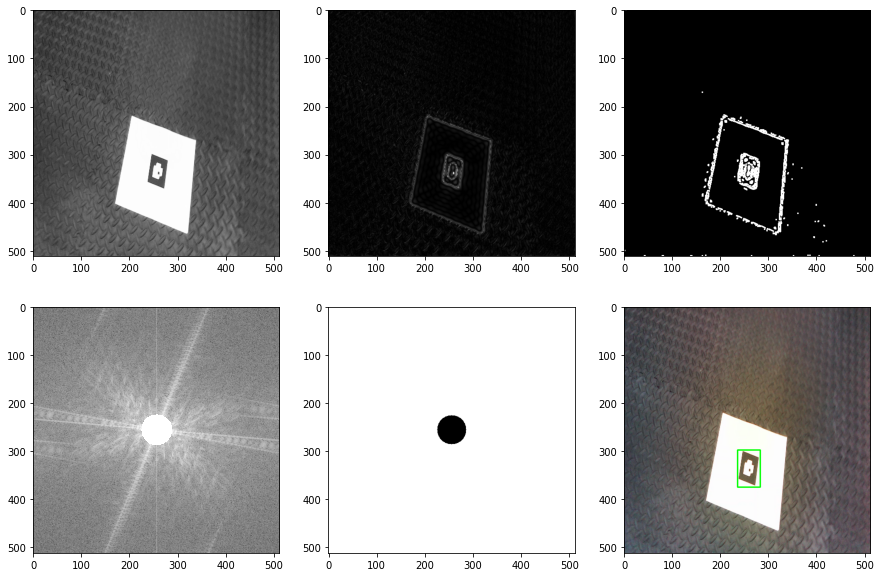

In [245]:
im_org = imgs[350].copy()
im_print, AR_tag = getAR_white(im_org, with_FFT = False)

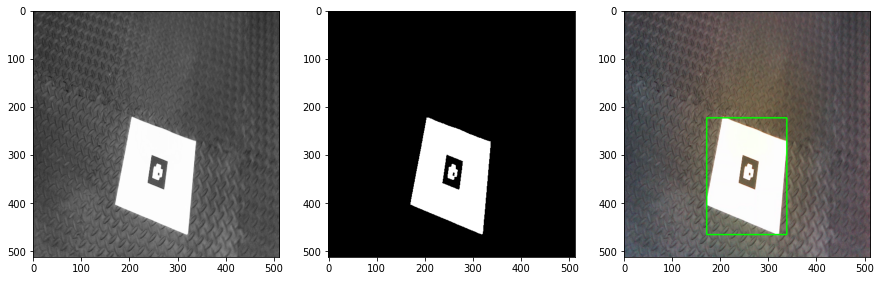

In [247]:
_, binary = cv2.threshold(im, 240, 255, cv2.THRESH_BINARY) 


kernel = np.ones((3,3),np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


Area_List = []
for c in contours:
    Area_List.append(cv2.contourArea(c))

i = np.argmax(np.array(Area_List))
rect = cv2.boundingRect(contours[i])
x,y,w,h = rect
margin = 10
AR_tag = im_org[y-margin:y+h+margin,x-margin:x+w+margin] # with 10pixel pad margin

im_print = im_org.copy()
cv2.rectangle(im_print,(x,y),(x+w,y+h),(0,255,0),2)

# rect = cv2.minAreaRect(contours[i])
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# box = box.reshape((-1,1,2))
# cv2.polylines(im_print,[box],True,(0,255,255))


fig,plts = plt.subplots(1,3,figsize = (15,10))
plts[0].imshow(im,'gray')
plts[1].imshow(binary,'gray')
plts[2].imshow(im_print)

In [243]:
# im_org = imgs[505].copy()
im_tracked = []
AR_tracked = []
invalidImageCounter= 0
for image in imgs:
    im_org = image.copy()
    im_print, AR_tag = getAR_white(im_org, margin = 10, with_FFT = True)
    AR_block, invalidImageCounter = getAR_block(AR_tag, invalidImageCounter)
    im_tracked.append(im_print)
    if AR_block is not None:
        AR_block  = cv2.resize(AR_block, (64,64))    
        AR_tracked.append(AR_block)

#     cv2.imshow("im_print",im_print)
print(invalidImageCounter)
outVideo = mpy.ImageSequenceClip(im_tracked, fps=25)
outVideo.write_videofile('im_tracked_2_fft.mp4')

outVideo = mpy.ImageSequenceClip(AR_tracked, fps=25)
outVideo.write_videofile('AR_tracked_2_fft.mp4')

Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 3
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 4
Finding the AR 4
Finding the white sheet 3
Finding the AR 3
Finding the white sheet 3
Finding the AR 3
Finding the

error: OpenCV(4.5.1) /tmp/pip-req-build-1syr35c1/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [9]:
im_AR = AR_tag.copy()

_, binary = cv2.threshold(cv2.cvtColor(im_AR, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

im_AR = cv2.drawContours(im_AR, contours[1], -1, (0, 255, 255), 2)

# find the contours of white space since directly AR is erroneous
parent_contour = contours[0]
parent_corners = cv2.approxPolyDP(parent_contour,0.01*cv2.arcLength(parent_contour,True),True) 

margin = 10
h,w = AR_tag.shape[:2]
h,w = h-2*margin, w-2*margin
reference_corners = np.array([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)

H = cv2.getPerspectiveTransform(np.float32(parent_corners), np.float32(reference_corners))
warped_AR_tag = cv2.warpPerspective(AR_tag, H, dsize =(w,h) )

_, binary = cv2.threshold(cv2.cvtColor(warped_AR_tag, cv2.COLOR_BGR2GRAY), 240, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

# warped_AR_tag_print = warped_AR_tag.copy()
# warped_AR_tag_print = cv2.drawContours(warped_AR_tag_print, contours[2], -1, (0, 255, 255), 2)

rect = cv2.boundingRect(contours[1])
x,y,w,h = rect
margin = 0
AR_block = warped_AR_tag[y-margin:y+h+margin,x-margin:x+w+margin] # with 10pixel pad margin

3
3


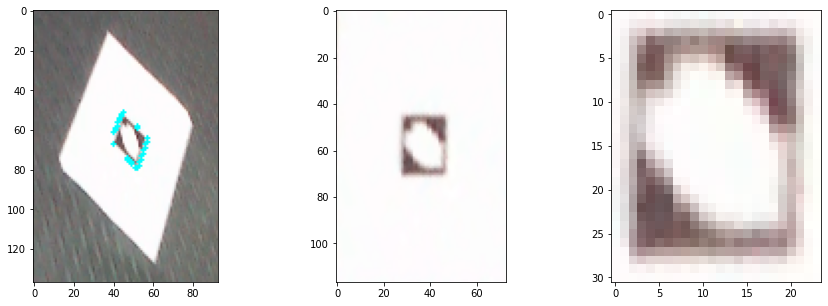

In [10]:
_,plts = plt.subplots(1,3,figsize = (15,5))
plts[0].imshow(im_AR)
plts[1].imshow(warped_AR_tag)
plts[2].imshow(AR_block)


 ### Learning Contours

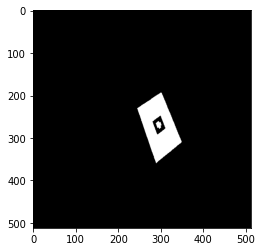

In [81]:
im1 = imgs[1].copy()
im_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
_, im1_binary = cv2.threshold(im_gray, 240, 255, cv2.THRESH_BINARY)
plt.imshow(im1_binary,'gray')
contours, hierarchy = cv2.findContours(im1_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

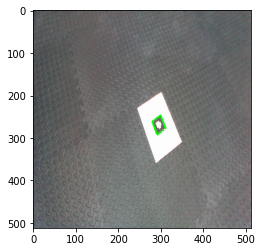

In [82]:
im_print = im1.copy()
im_print = cv2.drawContours(im_print, contours[1], -1, (0, 255, 0), 3)
plt.imshow(im_print, 'gray')

In [83]:
AR_contour = contours[1]

approx = cv2.approxPolyDP(AR_contour, 0.03 * cv2.arcLength(AR_contour, True), True)

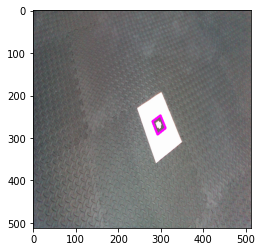

In [89]:
im_poly = im1.copy()
pts = approx.reshape((-1,1,2))
cv2.polylines(im_poly,[pts],True,(255,0,255),thickness = 3)

plt.imshow(im_poly)

261121.0


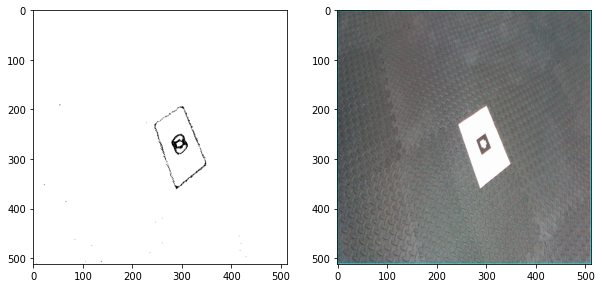

In [168]:
for c in contours:
    rect = cv2.boundingRect(c)
    if rect[2] < 100 or rect[3] < 100: continue
    print(cv2.contourArea(c))
    x,y,w,h = rect
    cv2.rectangle(im_org,(x,y),(x+w,y+h),(0,255,255),2)
    


fig,plts = plt.subplots(1,2,figsize = (10,5))
plts[0].imshow(binary,'gray')
plts[1].imshow(im_org)

## Learning FFT

/home/gokul/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


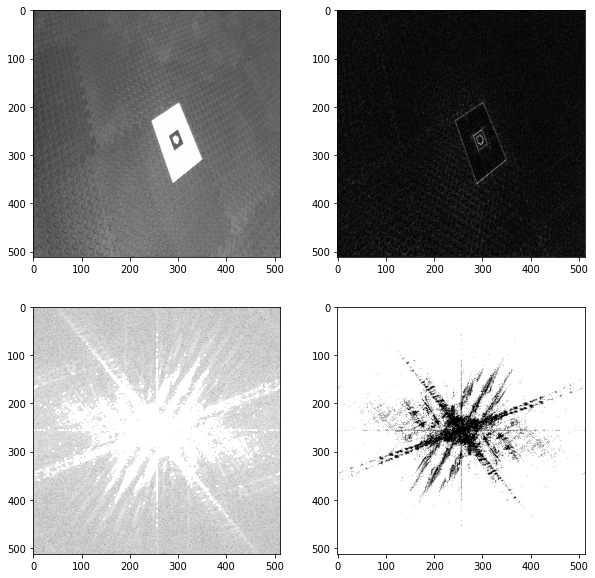

In [42]:
def getPassRegion(magnitude_spectrum,alpha): 
    size = magnitude_spectrum.shape[0]
    mask = np.ones((size,size,2))
#     mask[(dft_shift > alpha*dft_shift.max()) & (dft_shift < beta*magnitude_spectrum.max())] = 0
    mask[(magnitude_spectrum > alpha*magnitude_spectrum.max())] = 0
    return mask


im = imgs[0]
# im = cv2.GaussianBlur(im,(3,3),0)
# im = cv2.normalize(im.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)
dft = cv2.dft(np.float32(im),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

# mask = getCircularMask(dft_shift.shape, radius=150)
mask =  getPassRegion(magnitude_spectrum,alpha = 0.53)

fshift = dft_shift*mask
magnitude_spectrum_lp = 20*np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1]))
f_ishift = np.fft.ifftshift(fshift)
im_ = cv2.idft(f_ishift)
im_ = cv2.magnitude(im_[:,:,0],im_[:,:,1])


im_ = cv2.normalize(im_, None, 0.0, 1.0, cv2.NORM_MINMAX)
fig,plts = plt.subplots(2,2,figsize = (10,10))
plts[0][0].imshow(im,'gray')
plts[0][1].imshow(im_,'gray')
plts[1][0].imshow(magnitude_spectrum_lp,'gray')
plts[1][1].imshow(mask[:,:,0],'gray')